# Training Model 
## Saving the best model into pickle

In [2]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.2/124.9 MB 5.3 MB/s eta 0:00:24
   ---------------------------------------- 1.3/124.9 MB 16.4 MB/s eta 0:00:08
    --------------------------------------- 2.0/124.9 MB 15.9 MB/s eta 0:00:08
    --------------------------------------- 3.1/124.9 MB 17.9 MB/s eta 0:00:07
   - -------------------------------------- 4.3/124.9 MB 21.0 MB/s eta 0:00:06
   - -------------------------------------- 5.8/124.9 MB 23.1 MB/s eta 0:00:06
   -- ------------------------------------- 7.4/124.9 MB 24.7 MB/s eta 0:00:05
   -- ------------------------------------- 8.9/124.9 MB 24.9 MB/s eta 0:00:05
   --- ------------------------------------ 10.6/124.9 MB 28.5 MB/s eta 0:00:05
   --- ------------------------------------ 11.8/124.9 MB 31.2 MB/s eta 0:00:04
   ---- ----------------------------------- 13.2/124.9 MB 32

DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
  Using cached catboost-1.2.7-cp311-cp311-win_amd64.whl.metadata (1.2 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached catboost-1.2.7-cp311-cp311-win_amd64.whl (101.7 MB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)


DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.2/101.7 MB 4.1 MB/s eta 0:00:25
    --------------------------------------- 1.4/101.7 MB 12.6 MB/s eta 0:00:08
   - -------------------------------------- 3.0/101.7 MB 19.1 MB/s eta 0:00:06
   - -------------------------------------- 4.0/101.7 MB 21.1 MB/s eta 0:00:05
   -- ------------------------------------- 6.0/101.7 MB 23.8 MB/s eta 0:00:05
   -- ------------------------------------- 7.4/101.7 MB 25.0 MB/s eta 0:00:04
   --- ------------------------------------ 9.0/101.7 MB 26.2 MB/s eta 0:00:04
   --- ------------------------------------ 9.3/101.7 MB 25.9 MB/s eta 0:00:04
   ---- ----------------------------------- 12.0/101.7 MB 31.1 MB/s eta 0:00:03
   ----- ---------------------------------- 13.3/101.7 MB 31.2 MB/s eta 0:00:03
   ----- ---------------------------------- 14.9/101.7 MB 36

DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pickle
import json
from sklearn.preprocessing import MinMaxScaler

# Load the preprocessed feature file and the powerline file
features_file = pd.read_csv("C:/Users/anike/Downloads/satellite/'Preprocess_Feature_MEX.csv")
powerline_file = pd.read_csv("C:/Users/anike/Downloads/satellite/Power_Satellite.csv")

# Convert 'ut_ms' columns to datetime and align both datasets
features_file['ut_ms'] = pd.to_datetime(features_file['ut_ms'])
powerline_file['ut_ms'] = pd.to_datetime(powerline_file['ut_ms'])

# Merge datasets on the timestamp ('ut_ms')
merged_data = pd.merge(features_file, powerline_file[['ut_ms', 'NPWD2372']], on='ut_ms')

# Set the timestamp as index
merged_data.set_index('ut_ms', inplace=True)

# Define window parameters
window_size = pd.Timedelta(hours=7)  # 7 hours window
overlap_size = pd.Timedelta(hours=1)  # 1 hour overlap
step_size = window_size - overlap_size

# Prepare a scaler to normalize the features
scaler = MinMaxScaler()

# Create a function to train models and return the model with the best RMSE score
def train_models(X_train, y_train, X_test, y_test):
    models = {
        'RandomForest': RandomForestRegressor(),
        'XGBoost': XGBRegressor(),
        'CatBoost': CatBoostRegressor(verbose=0)
    }
    best_model = None
    best_rmse = float('inf')
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = (name, model)
    
    return best_model, best_rmse

# Create a directory for saving pickle files
output_dir = 'models_pickle'
os.makedirs(output_dir, exist_ok=True)

# Initialize metadata dictionary
metadata = []

# Track previous best model
prev_best_model = None
current_window_data = []
file_counter = 1

# Iterate over time windows
start_time = merged_data.index.min()
end_time = merged_data.index.max()

while start_time + window_size <= end_time:
    window_end = start_time + window_size
    window_data = merged_data.loc[start_time:window_end]
    
    # Ensure there is data in the current window
    if window_data.empty:
        start_time += step_size
        continue

    # Split into features (X) and target (y)
    X = window_data.drop(columns=['NPWD2372'])
    y = window_data['NPWD2372']
    
    # Ensure there is sufficient data to split
    if len(X) < 2 or len(y) < 2:
        start_time += step_size
        continue
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Normalize the data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train the models and get the best model for this window
    best_model, best_rmse = train_models(X_train, y_train, X_test, y_test)
    
    # Ensure best_model is valid
    if not best_model:
        start_time += step_size
        continue
    
    # Check if this window's model is the same as the previous window
    if prev_best_model and prev_best_model[0] == best_model[0]:
        # If the model is the same, extend the current window
        current_window_data.append((start_time, window_end, best_model[1], best_rmse))
    else:
        # If the model has changed, save the previous model data to a pickle file and update metadata
        if prev_best_model:
            # Save the pickle file
            model_file_path = os.path.join(output_dir, f'model_{prev_best_model[0]}_window_{file_counter}.pkl')
            with open(model_file_path, 'wb') as f:
                pickle.dump(prev_best_model[1], f)
            
            # Update metadata with the start and end time for the model
            metadata.append({
                'model_name': prev_best_model[0],
                'file_path': model_file_path,
                'start_time': str(current_window_data[0][0]),
                'end_time': str(current_window_data[-1][1]),
                'rmse': best_rmse
            })
        
        # Start a new window for the current model
        file_counter += 1
        prev_best_model = best_model
        current_window_data = [(start_time, window_end, best_model[1], best_rmse)]
    
    # Shift the window by the step size (7 hours - 1 hour overlap)
    start_time += step_size

# Save the final model and metadata
if prev_best_model:
    model_file_path = os.path.join(output_dir, f'model_{prev_best_model[0]}_window_{file_counter}.pkl')
    with open(model_file_path, 'wb') as f:
        pickle.dump(prev_best_model[1], f)

    # Update metadata for the final model
    metadata.append({
        'model_name': prev_best_model[0],
        'file_path': model_file_path,
        'start_time': str(current_window_data[0][0]),
        'end_time': str(current_window_data[-1][1]),
        'rmse': best_rmse
    })

# Save metadata to a JSON file
with open(os.path.join(output_dir, 'metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"Model training and saving complete. All models are saved in the '{output_dir}' folder.")


C:\Users\anike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\anike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\anike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\anike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 an

Model training and saving complete. All models are saved in the 'models_pickle' folder.


C:\Users\anike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Plotting Actual vs Predicted graph


Best Overall Model: RandomForest
RMSE: 0.0124
Model file: models_pickle\model_RandomForest_window_9.pkl


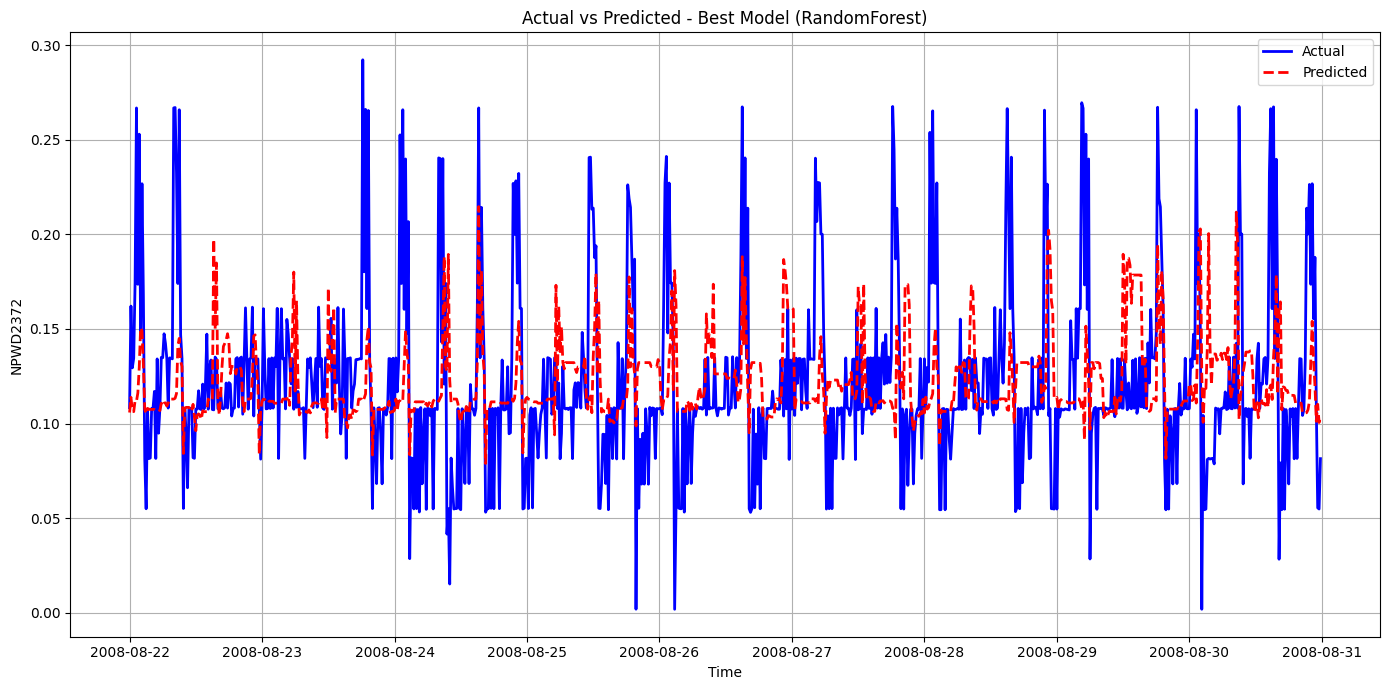

In [38]:
import matplotlib.pyplot as plt

with open('models_pickle/metadata.json', 'r') as f:
    metadata = json.load(f)

#find the best overall model
best_model_info = min(metadata, key=lambda x: x['rmse'])
best_model_path = best_model_info['file_path']
best_model_rmse = best_model_info['rmse']


print(f"Best Overall Model: {best_model_info['model_name']}")
print(f"RMSE: {best_model_rmse:.4f}")
print(f"Model file: {best_model_path}")

#Load the best model from the pickle file
with open(best_model_path, 'rb') as f:
    best_model = pickle.load(f)


X_test = scaler.transform(merged_data.drop(columns=['NPWD2372']))  
y_test = merged_data['NPWD2372']

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Plot the actual vs predicted line chart
plt.figure(figsize=(14, 7))
plt.plot(merged_data.index, y_test, label='Actual', color='blue', linewidth=2)
plt.plot(merged_data.index, y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)

plt.title(f"Actual vs Predicted - Best Model ({best_model_info['model_name']})")
plt.xlabel('Time')
plt.ylabel('NPWD2372')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


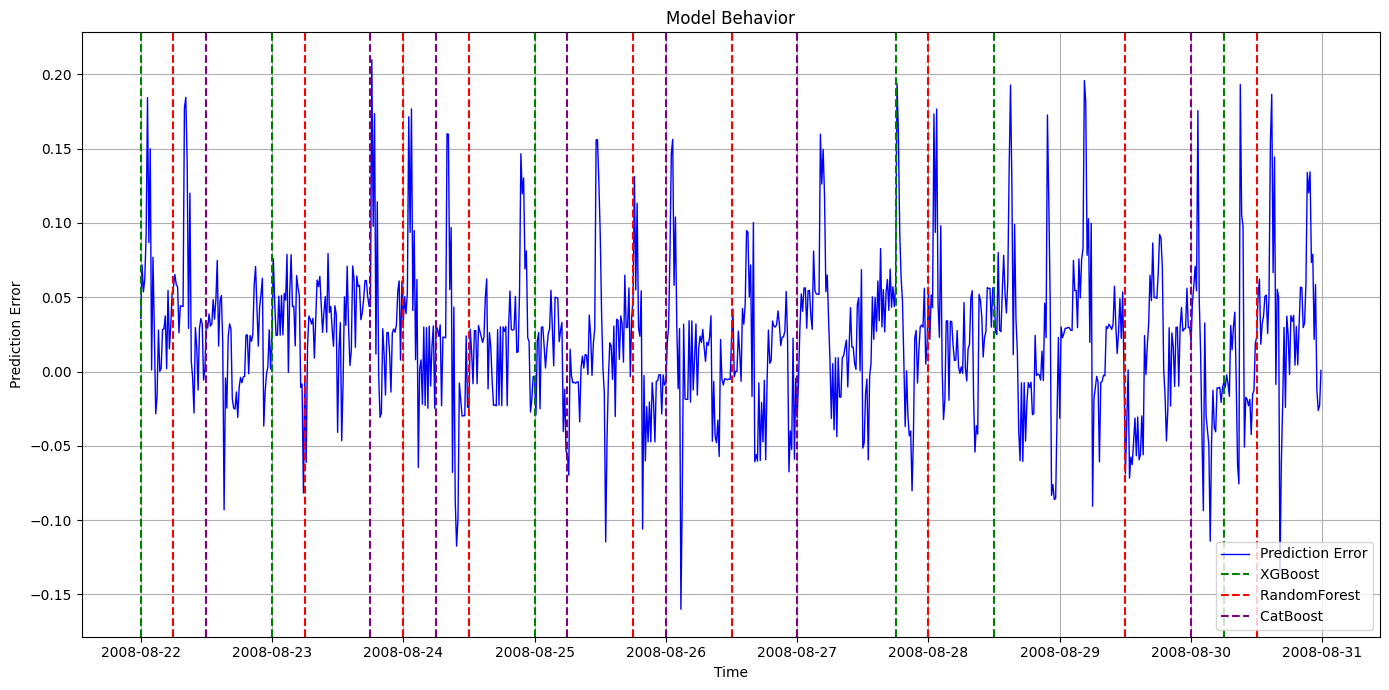

In [35]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

X_test = scaler.transform(merged_data.drop(columns=['NPWD2372']))  
y_test = merged_data['NPWD2372']

y_pred = best_model.predict(X_test)

prediction_error = y_test - y_pred

fig, ax = plt.subplots(figsize=(14, 7))

#Plot the prediction error
ax.plot(merged_data.index, prediction_error, label='Prediction Error', color='blue', linewidth=1)


model_colors = {
    'XGBoost': 'green',
    'RandomForest': 'red',
    'CatBoost': 'purple'
}

# Loop over the metadata to mark where model behavior changes
for entry in metadata:
    model_name = entry['model_name']
    model_start_time = pd.to_datetime(entry['start_time'])
    model_end_time = pd.to_datetime(entry['end_time'])

    # Mark model change with a vertical line using the corresponding color
    plt.axvline(x=model_start_time, color=model_colors.get(model_name, 'black'), linestyle='--', label=f'{model_name} ')

plt.title('Model Behavior')
plt.xlabel('Time')
plt.ylabel('Prediction Error')


ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower right')

plt.grid(True)
plt.tight_layout()
plt.show()
